In [1]:
import evals
from tensorflow import keras
import tensorflow as tf
import IJB_evals
import matplotlib.pyplot as plt
import keras_cv_attention_models
import GhostFaceNets, GhostFaceNets_with_Bias
from models import NormDense, NormDenseVPL

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
custom_objects = {
    "NormDense": NormDense,
    "NormDenseVPL": NormDenseVPL
}

model_path = 'base_model_no_changes_5k_images/ghostnetv1_w1.3_s2_basic_model_latest.h5'
model_base = keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [4]:
model_path = 'checkpoints/ghostnetv1_w1.3_s2_basic_model_latest.h5'
model_vae = keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)

In [5]:
import numpy as np
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from keras.utils import load_img, img_to_array
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt

def generate_embedding(model, img_path):
    img = load_img(img_path, target_size=(112, 112))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    embedding = model.predict(img_array)
    return embedding

In [6]:
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


image_folder = 'datasets/test'
embeddings_base = []
embeddings_vae = []

for i in range(50):
    subfolder_path = os.path.join(image_folder, str(i))
    if os.path.isdir(subfolder_path):
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)
            embedding_base = generate_embedding(model_base, img_path)
            embedding_vae = generate_embedding(model_vae, img_path)
            embeddings_base.append(embedding_base)
            embeddings_vae.append(embedding_vae)

embeddings_base = np.array(embeddings_base).squeeze()
embeddings_vae = np.array(embeddings_vae).squeeze()

1/1 [==============================] - 0s 43ms/step


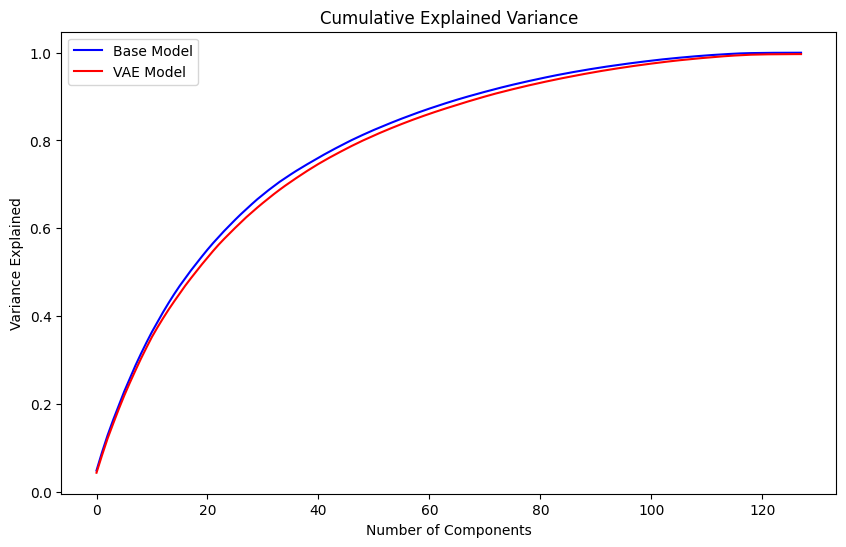

In [9]:
pca_base = PCA(n_components=128)
pca_base.fit(embeddings_base)
explained_variance_base = pca_base.explained_variance_ratio_

pca_vae = PCA(n_components=128)
pca_vae.fit(embeddings_vae)
explained_variance_vae = pca_vae.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_base), label='Base Model', color='blue')
plt.plot(np.cumsum(explained_variance_vae), label='VAE Model', color='red')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.savefig("variance3.png")